In [22]:
import librosa
import pandas as pd
import numpy as np
import os
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import SGDRegressor
from xgboost import XGBClassifier
from  sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from datetime import datetime
import time
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint


In [48]:
# def noise(data):
#     noise_amp = 0.035*np.random.uniform()*np.amax(data)
#     data = data + noise_amp*np.random.normal(size=data.shape[0])
#     return data

# def stretch(data, rate=0.8):
#     return librosa.effects.time_stretch(data, rate)

# def shift(data):
#     shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
#     return np.roll(data, shift_range)

# def pitch(data, sampling_rate, pitch_factor=0.7):
#     return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


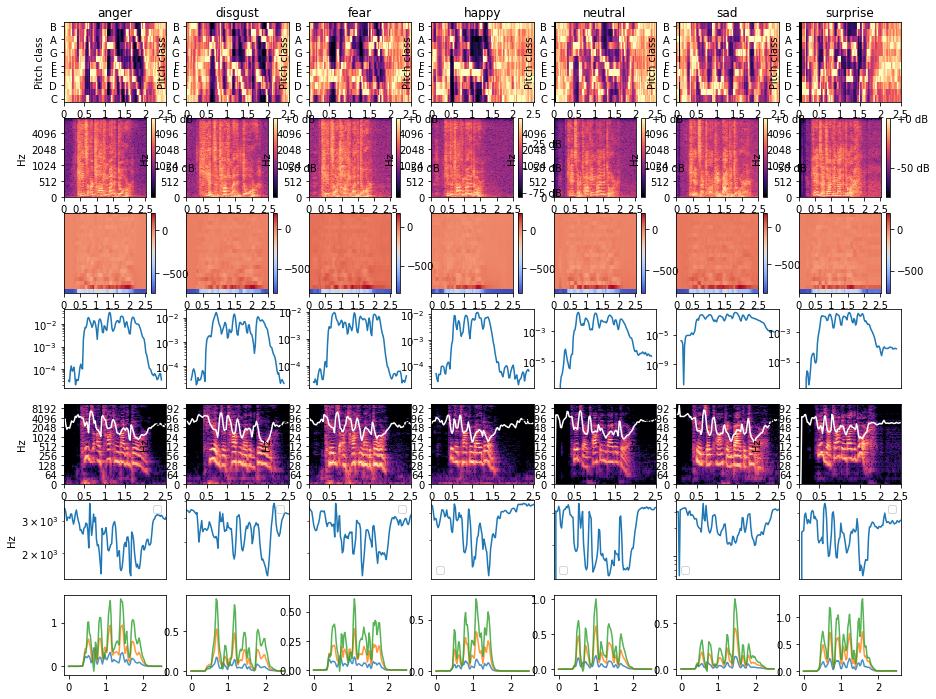

In [125]:
spath=["Dataset/anger/anger011.wav", "Dataset/disgust/disgust011.wav","Dataset/fear/fear011.wav","Dataset/happy/happy011.wav","Dataset/neutral/neutral003.wav","Dataset/sad/sad003.wav","Dataset/surprise/surprise003.wav"]
emotion = ["anger","disgust", "fear", "happy", "neutral", "sad","surprise"]
import matplotlib.pyplot as plt
import librosa.display
fig, ax = plt.subplots(7,7,figsize=(15,12))
for path, num, emo in zip(spath,range(7), emotion):
    y, sr = librosa.load(path, duration=2.5, offset=0.6)
    S = np.abs(librosa.stft(y))
    chroma = librosa.feature.chroma_stft(S=S, sr=sr)
    img = librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', ax=ax[0,num])
    ax[0,num].set(title=emo)
    
    S_dB = librosa.power_to_db(S, ref=np.max)
    img1 = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax[1,num])
    fig.colorbar(img1, ax=ax[1,num], format='%+2.0f dB')
    
    m_slaney = librosa.feature.mfcc(y=y, sr=sr, dct_type=2)
    img2 = librosa.display.specshow(m_slaney, x_axis='time', ax=ax[2, num])
    fig.colorbar(img2, ax=ax[2 ,num])
    
    S1, phase = librosa.magphase(librosa.stft(y))
    rms = librosa.feature.rms(S=S1)
    times = librosa.times_like(rms)
    ax[3,num].semilogy(times, rms[0], label='RMS Energy')
    ax[3,num].set(xticks=[])
#     ax[3,num].legend()

    
    
    cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    times = librosa.times_like(cent)
    librosa.display.specshow(librosa.amplitude_to_db(S1, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax[4,num])
    ax[4,num].plot(times, cent.T, label='Spectral centroid', color='w')
#     ax[4,num].legend(loc='upper right')
    
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    times = librosa.times_like(spec_bw)
    centroid = librosa.feature.spectral_centroid(S=S1)
    ax[5,num].semilogy(times, spec_bw[0])
    ax[5,num].set(ylabel='Hz', xticks=[], xlim=[times.min(), times.max()])
    ax[5,num].legend()
    ax[5,num].label_outer()
    
    p0 = librosa.feature.poly_features(S=S, order=0)
    p1 = librosa.feature.poly_features(S=S, order=1)
    p2 = librosa.feature.poly_features(S=S, order=2)
    ax[6,num].plot(times, p0[0], label='order=0', alpha=0.8)
    ax[6,num].plot(times, p1[1], label='order=1', alpha=0.8)
    ax[6,num].plot(times, p2[2], label='order=2', alpha=0.8)
#     ax[6,num].legend()
        
    
plt.savefig('foo.png')  

In [23]:
def extract_features(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
   
    result = np.array([])
    
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) 


    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) 
    
#     chroma_cq = np.mean(librosa.feature.chroma_cqt(y=data, sr=sample_rate).T, axis=0)
#     result = np.hstack((result, chroma_cq)) # stacking horizontally
    
#     chroma_cens = np.mean(librosa.feature.chroma_cens(y=data, sr=sample_rate).T, axis=0)
#     result = np.hstack((result, chroma_cens))
    

    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) 

    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) 


    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) 
    
    
    cent  = np.mean(librosa.feature.spectral_centroid(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, cent)) 
    
    sb = np.mean(librosa.feature.spectral_bandwidth(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, sb)) 
    
    sc = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, sc)) 
    
    sf = np.mean(librosa.feature.spectral_flatness(y=data).T, axis=0)
    result = np.hstack((result, sf)) 
    
    sr = np.mean(librosa.feature.spectral_rolloff(y=data, sr=sample_rate, roll_percent=0.95).T, axis=0)
    result = np.hstack((result, sr)) 
    
    sc = np.mean(librosa.feature.poly_features(S=stft, order=2).T, axis=0)
    result = np.hstack((result, sc)) 
    
    ton = np.mean(librosa.feature.tonnetz(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, ton)) 
    return np.array(result)



In [4]:
pd.DataFrame(extract_features("Dataset/anger/anger003.wav"))

D:\anaconda3\envs\py37\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=862
  n_fft, y.shape[-1]


0
0    0.159428
1    0.633866
2    0.673497
3    0.650660
4    0.651187
..        ...
177  0.007734
178 -0.008309
179  0.001072
180  0.004505
181 -0.009307

[182 rows x 1 columns]

In [4]:
data, sample_rate = librosa.load("Dataset/anger/anger003.wav", duration=2.5, offset=0.6)
data
sample_rate

22050

In [127]:
X, Y = [], []
dir = 'Dataset/'
for root, dirs, files in os.walk(dir):
    for file in files:
        emotion = root.split("/")
        path = emotion[0]+"/"+emotion[1]+"/" + file
        feature = extract_features(path)
        X.append(feature)
        Y.append(emotion[1])
        
X

D:\anaconda3\envs\py37\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=862
  n_fft, y.shape[-1]
D:\anaconda3\envs\py37\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=1017
  n_fft, y.shape[-1]
D:\anaconda3\envs\py37\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=509
  n_fft, y.shape[-1]
D:\anaconda3\envs\py37\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=733
  n_fft, y.shape[-1]
D:\anaconda3\envs\py37\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=827
  n_fft, y.shape[-1]
D:\anaconda3\envs\py37\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=718
  n_fft, y.shape[-1]
D:\anaconda3\envs\py37\lib\site-package

D:\anaconda3\envs\py37\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=676
  n_fft, y.shape[-1]
D:\anaconda3\envs\py37\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=782
  n_fft, y.shape[-1]
D:\anaconda3\envs\py37\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=684
  n_fft, y.shape[-1]
D:\anaconda3\envs\py37\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=697
  n_fft, y.shape[-1]
D:\anaconda3\envs\py37\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=622
  n_fft, y.shape[-1]
D:\anaconda3\envs\py37\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=711
  n_fft, y.shape[-1]
D:\anaconda3\envs\py37\lib\site-packages

D:\anaconda3\envs\py37\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=817
  n_fft, y.shape[-1]
D:\anaconda3\envs\py37\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=873
  n_fft, y.shape[-1]
D:\anaconda3\envs\py37\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=437
  n_fft, y.shape[-1]
D:\anaconda3\envs\py37\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=628
  n_fft, y.shape[-1]
D:\anaconda3\envs\py37\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=704
  n_fft, y.shape[-1]
D:\anaconda3\envs\py37\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=811
  n_fft, y.shape[-1]
D:\anaconda3\envs\py37\lib\site-packages

[array([ 2.12226020e-01,  5.96274555e-01,  6.43111765e-01,  6.62050784e-01,
         7.09678173e-01,  6.56572580e-01,  6.32118464e-01,  6.17637575e-01,
         5.90883434e-01,  6.02890491e-01,  6.86652303e-01,  6.71709478e-01,
         5.81885695e-01, -4.44575348e+02,  6.61792374e+01, -1.00770731e+01,
         2.00366688e+01, -2.98816466e+00, -3.98052669e+00, -7.27629995e+00,
        -1.80031109e+00, -1.98992195e+01, -6.88279963e+00, -1.89719105e+00,
        -6.84589815e+00, -1.67782485e+00, -6.66277742e+00, -5.63006258e+00,
        -2.33086872e+00, -1.00880518e+01, -2.46657133e+00, -6.64936495e+00,
        -4.79859877e+00,  1.34263877e-02,  6.08993368e-03,  2.23571179e-03,
         3.46250483e-03,  2.19792016e-02,  2.44666412e-01,  6.21509075e-01,
         2.07729951e-01,  1.11196384e-01,  2.38722771e-01,  5.94212055e-01,
         3.01030338e-01,  3.58231008e-01,  1.15816787e-01,  8.94789174e-02,
         1.13523580e-01,  1.74607977e-01,  3.57623488e-01,  7.89482415e-01,
         4.6

In [128]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features1.csv', index=False)
Features

0         1         2         3         4         5         6  \
0  0.212226  0.596275  0.643112  0.662051  0.709678  0.656573  0.632118   
1  0.225703  0.648670  0.573467  0.582980  0.613950  0.675278  0.655215   
2  0.159428  0.633866  0.673497  0.650660  0.651187  0.669287  0.690864   
3  0.231472  0.597927  0.573042  0.613137  0.640094  0.612050  0.599891   
4  0.138396  0.664913  0.699104  0.685874  0.639992  0.604898  0.599895   

          7         8         9  ...           173       174       175  \
0  0.617638  0.590883  0.602890  ...  7.824248e-09 -0.000122  0.466763   
1  0.652851  0.656304  0.656713  ...  5.357313e-09 -0.000084  0.323450   
2  0.713079  0.727692  0.773747  ...  2.573068e-09 -0.000038  0.144084   
3  0.639796  0.601819  0.613994  ...  5.211700e-09 -0.000082  0.327484   
4  0.567348  0.595946  0.588052  ...  1.009118e-08 -0.000158  0.613845   

        176       177       178       179       180       181  labels  
0 -0.055023  0.025026  0.026016 -0.017109  0.006058  0.024826   anger  
1 -0.000517  0.035617 -0.027661  0.061720  0.011559  0.012816   anger  
2 -0.030945  0.007734 -0.008309  0.001072  0.004505 -0.009307   anger  
3 -0.019090  0.009554 -0.020602 -0.018078  0.003646  0.014934   anger  
4 -0.019726  0.019465 -0.039276 -0.004664  0.005326 -0.009324   anger  

[5 rows x 183 columns]

In [24]:
Features = pd.read_csv('features1.csv')
x = Features.drop('labels',1)
y = Features["labels"]
# from sklearn.preprocessing import LabelEncoder
# labelencoder = LabelEncoder()
# y = labelencoder.fit_transform(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=22)
x_train.shape, x_test.shape, y_train.shape, y_test.shape


((1917, 182), (639, 182), (1917,), (639,))

In [25]:
transfer = StandardScaler()
x_train = transfer.fit_transform(x_train)
joblib.dump(transfer, 'std_scaler.bin', compress=True)
x_test = transfer.transform(x_test)


In [7]:
knn_estimator = KNeighborsClassifier( n_jobs=7)
# Prepare the hyperparameters to be tuned, use GridSearch find a good value K
param_dict = {"n_neighbors": [5,7,9]}
knn_estimator = GridSearchCV(knn_estimator, param_grid=param_dict, cv=3)
knn_estimator.fit(x_train, y_train)

# KNN Model evaluation
y_predict = knn_estimator.predict(x_test)
# Print the results
print(classification_report(y_test,y_predict, digits=3))

              precision    recall  f1-score   support

       anger      0.672     0.759     0.713       108
     disgust      0.448     0.526     0.484        57
        fear      0.494     0.384     0.432       112
       happy      0.657     0.633     0.645       109
     neutral      0.642     0.864     0.737        81
         sad      0.693     0.550     0.613       111
    surprise      0.574     0.574     0.574        61

    accuracy                          0.610       639
   macro avg      0.597     0.613     0.600       639
weighted avg      0.609     0.610     0.604       639



In [163]:
lr_estimator = LogisticRegression()
lr_estimator.fit(x_train, y_train)

#LR Model evaluation
y_predict = lr_estimator.predict(x_test)
# Print the results
print(classification_report(y_test,y_predict, digits=3))

              precision    recall  f1-score   support

       anger      0.643     0.667     0.655       108
     disgust      0.371     0.404     0.387        57
        fear      0.519     0.500     0.509       112
       happy      0.645     0.651     0.648       109
     neutral      0.648     0.728     0.686        81
         sad      0.606     0.514     0.556       111
    surprise      0.629     0.639     0.634        61

    accuracy                          0.590       639
   macro avg      0.580     0.586     0.582       639
weighted avg      0.590     0.590     0.589       639



D:\anaconda3\envs\py37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [26]:
#XGBoost model
xgboost = XGBClassifier(random_state=1,n_jobs = 7)
xgboost.fit(x_train, y_train)

#LR Model evaluation
y_predict = xgboost.predict(x_test)
# Print the results
print(classification_report(y_test,y_predict, digits=3))

D:\anaconda3\envs\py37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:37:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

       anger      0.763     0.833     0.796       108
     disgust      0.458     0.474     0.466        57
        fear      0.626     0.643     0.634       112
       happy      0.747     0.679     0.712       109
     neutral      0.753     0.753     0.753        81
         sad      0.709     0.703     0.706       111
    surprise      0.719     0.672     0.695        61

    accuracy                          0.693       639
   macro avg      0.682     0.680     0.680       639
weighted avg      0.694     0.693     0.693       639



In [28]:
joblib.dump(xgboost, 'xgboost.pkl') 

['xgboost.pkl']

In [174]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(x_train, y_train)
y_predict = clf.predict(x_test)
# Print the results
print(classification_report(y_test,y_predict, digits=3))

              precision    recall  f1-score   support

       anger      0.686     0.648     0.667       108
     disgust      0.333     0.316     0.324        57
        fear      0.525     0.375     0.438       112
       happy      0.638     0.615     0.626       109
     neutral      0.690     0.716     0.703        81
         sad      0.587     0.640     0.612       111
    surprise      0.419     0.639     0.506        61

    accuracy                          0.571       639
   macro avg      0.554     0.564     0.554       639
weighted avg      0.576     0.571     0.569       639



In [211]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=200, random_state=1)
clf.fit(x_train, y_train)
y_predict = clf.predict(x_test)
print(classification_report(y_test,y_predict, digits=3))

              precision    recall  f1-score   support

       anger      0.704     0.704     0.704       108
     disgust      0.387     0.421     0.403        57
        fear      0.587     0.482     0.529       112
       happy      0.648     0.624     0.636       109
     neutral      0.744     0.827     0.784        81
         sad      0.632     0.649     0.640       111
    surprise      0.574     0.639     0.605        61

    accuracy                          0.626       639
   macro avg      0.611     0.621     0.614       639
weighted avg      0.626     0.626     0.624       639



In [212]:
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
     max_depth=5, random_state=1)
clf.fit(x_train, y_train)
y_predict = clf.predict(x_test)
print(classification_report(y_test,y_predict, digits=3))

              precision    recall  f1-score   support

       anger      0.792     0.741     0.766       108
     disgust      0.464     0.456     0.460        57
        fear      0.591     0.607     0.599       112
       happy      0.664     0.688     0.676       109
     neutral      0.824     0.753     0.787        81
         sad      0.669     0.712     0.690       111
    surprise      0.532     0.541     0.537        61

    accuracy                          0.660       639
   macro avg      0.648     0.643     0.645       639
weighted avg      0.664     0.660     0.662       639



In [142]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                     hidden_layer_sizes=(10500,), random_state=1)
clf.fit(x_train, y_train)
y_predict = clf.predict(x_test)
print(classification_report(y_test,y_predict, digits=3))

              precision    recall  f1-score   support

       anger      0.778     0.843     0.809       108
     disgust      0.556     0.526     0.541        57
        fear      0.660     0.589     0.623       112
       happy      0.772     0.807     0.789       109
     neutral      0.767     0.852     0.807        81
         sad      0.763     0.667     0.712       111
    surprise      0.627     0.689     0.656        61

    accuracy                          0.720       639
   macro avg      0.703     0.710     0.705       639
weighted avg      0.718     0.720     0.717       639



In [17]:
# joblib.dump(clf, 'MLP.pkl') 
clf = joblib.load('MLP.pkl')


In [14]:
import pyaudio
import wave
 
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 44100
CHUNK = 1024
RECORD_SECONDS = 3
 
audio = pyaudio.PyAudio()
 
# start Recording
stream = audio.open(format=FORMAT, channels=CHANNELS,
                rate=RATE, input=True,
                frames_per_buffer=CHUNK)
print("recording...")
frames = []
 
for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data)
print("finished recording")
 
# stop Recording
stream.stop_stream()
stream.close()
audio.terminate()
 
waveFile = wave.open("demo.wav", 'wb')
waveFile.setnchannels(CHANNELS)
waveFile.setsampwidth(audio.get_sample_size(FORMAT))
waveFile.setframerate(RATE)
waveFile.writeframes(b''.join(frames))
waveFile.close()

recording...
finished recording


In [20]:
transfer=joblib.load('std_scaler.bin')

In [21]:
test = extract_features("demo.wav")
test = pd.DataFrame(test)
test = test.T
test = transfer.transform(test)
y_pred  = clf.predict_proba(test)
y_pred

D:\anaconda3\envs\py37\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=826
  n_fft, y.shape[-1]


array([[1.34328331e-12, 9.99892005e-01, 8.33421840e-19, 2.32957027e-19,
        1.07931895e-04, 6.27326350e-08, 2.01213073e-11]])

In [146]:
([[8.45617987e-84, 4.22889768e-73, 5.96620999e-92, 1.00000000e+00,
        1.38204409e-74, 1.31231586e-75, 2.90717458e-65]])

1.786332133051857e-224